<a href="https://colab.research.google.com/github/isa-ulisboa/greends-pml/blob/main/notebooks/forest_fire_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("vikasukani/forest-firearea-datasets")

print("Path to dataset files:", path)
df=pd.read_csv(path+'/forestfires.csv')




100%|██████████| 7.10k/7.10k [00:00<00:00, 15.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/vikasukani/forest-firearea-datasets/versions/1


In [2]:

# Rename 'area' column to 'y' and the rest to 'X'
y = df['area']
X = df.drop(['X', 'Y','area'], axis=1)

In [3]:
X.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain'],
      dtype='object')

In [11]:
import pandas as pd
# pre-processing, missing values
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer

# to pass model to a function
from sklearn.base import clone

# pipeline
from sklearn.pipeline import Pipeline

# some models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# partition data
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_validate

# precision metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [5]:
categorical_features = ['month', 'day']
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

numeric_features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind','rain']
numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'mean')),
        ('normalizer', Normalizer())
    ]
)

In [6]:
preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, categorical_features),
        ('numericals', numeric_transformer, numeric_features)
    ],
    remainder = 'drop' # By default, only the specified columns in transformers are transformed and combined in the output, and the non-specified columns are dropped.
)


In [9]:

pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        #('clf', RandomForestClassifier(n_estimators=10))
        ('clf', xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1))
    ]
)


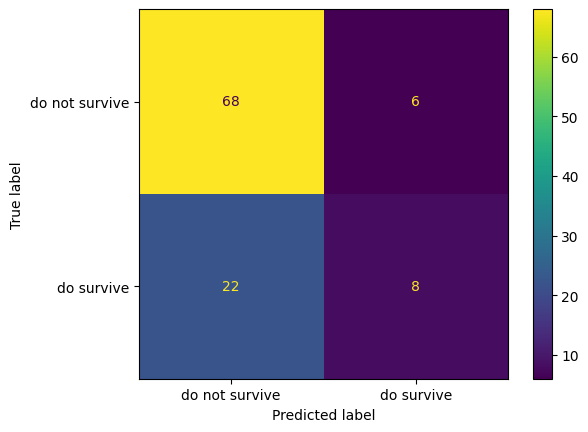

In [10]:
# Rename 'area' column to 'y' and the rest to 'X'
y = df['area']
X = df.drop(['X', 'Y','area'], axis=1)
y= y >5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

pipeline.fit(X_train, y_train)

y_pred=pipeline.predict(X_test)

# confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred) #actual, predicted
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmat, display_labels = ['do not survive', 'do survive'])
cm_display.plot()
plt.show()

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=94)

results = []

def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    y_pred=pipeline.predict(X_test)
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred) #actual, predicted
    return confmat

for train, test in cv.split(X, y):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    confmat = fit_and_score(clone(pipeline), X_train, X_test, y_train, y_test)
    results.append(confmat)

In [18]:
print(results)

[array([[61, 13],
       [25,  5]]), array([[63, 10],
       [26,  5]]), array([[63, 10],
       [23,  7]]), array([[61, 12],
       [28,  2]]), array([[62, 11],
       [27,  3]])]
